# Pyladies Meetup Week Two: Bayes in Practice

## Meant for an "after work" live presentation
This notebook is meant for a live presentation and may be confusing to follow without direct explanation. It also is a very quick treatment of Bayes Theorem for the mean for the "after work exhausted professional".

If you're interested after this tutorial I would suggest reading

* Bayesian Analysis with Python - Osvaldo Martin
* Statistical Rethinking - Richard McElreath

In [1]:
import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


## Agenda
1. Bayes Refresher from last week
2. A case of a little data and a lot of data
3. Linear Regression
    * Least Squares Method
    * Bayesian Method
5. Real world example
6. Why's this useful?

## Refresher
Bayesian methods let us 
* Define our own model of how data is generated
* Incorporate prior beliefs
* Estimate uncertainty in our beliefs given data/observations

Last week this is how we did it with our cards data

Number of Red Observations 2, Total Number of Observations 5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_red]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:06<00:00, 1712.42draws/s]


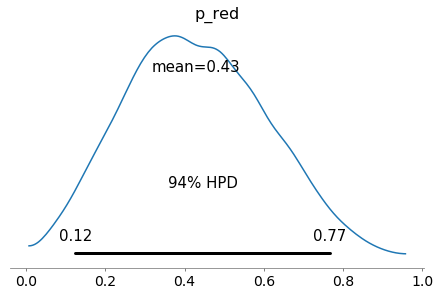

In [2]:
observations = [0, 0, 0, 1, 1]
red_observations = sum(observations)
total_observations = len(observations)
print(f"Number of Red Observations {red_observations}, Total Number of Observations {total_observations}")

with pm.Model() as five_obs_model:
    # Prior
    p_red = pm.Uniform("p_red", 0, 1)
    
    # Likelihood
    num_red = pm.Binomial("number_observed_red", p=p_red, n=total_observations, observed=red_observations)
    trace_binomial = pm.sample(draws=5000)
    
az.plot_posterior(trace_binomial);

## Linear Regression: The next obligatory statistics example
Let's simulate some linear data. We'll simulate some noise/error that always occurs in real life as well.

In [3]:
np.random.seed(0)
sample_size = 10

# Generate random values between 1 and 50
x = np.random.randint(20, 50, sample_size)

intercept = 10
slope = 2

# Generate y values using out slope and intercept
y= x*slope + intercept

# Add some noise in using a zero centered Gaussian/Normal Distribution
noise = 3
noisy_y = y + stats.norm(0, noise).rvs(sample_size)

x[:10], noisy_y[:10]

(array([32, 35, 41, 20, 23, 47, 23, 27, 29, 39]),
 array([ 71.47182784,  85.90977334,  95.79835559,  48.48237038,
         63.63560234, 107.24243574,  57.45293646,  65.73742144,
         67.45525228,  92.23061389]))

In [4]:
slope, intercept, r_value, p_value, std_err = stats.linregress(x, noisy_y)
slope, intercept, r_value, p_value, std_err

(2.098083473268639,
 9.24222117477855,
 0.9859735912820652,
 1.6650805641793438e-07,
 0.12556611746463195)

## Standard Linear Regression

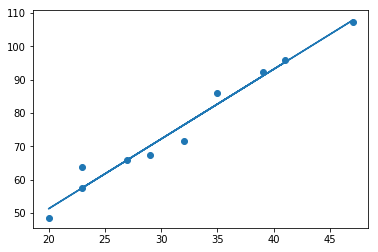

In [5]:
fig, ax = plt.subplots()

# Plot Dots
ax.scatter(x, noisy_y)

# Plot Best Fit Line
_x = np.linspace(0, 20, 1000)
ax.plot(x, x*slope+intercept)

Does a linear regression answer?
1. How noisy the data is?
2. What future data will look like?

## Bayes Linear Regression

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [noise_estimate, intercept_estimate, slope_estimate]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:10<00:00, 1039.37draws/s]
The acceptance probability does not match the target. It is 0.8897258193640742, but should be close to 0.8. Try to increase the number of tuning steps.


(<Figure size 432x475.2 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c227838d0>],
       dtype=object))

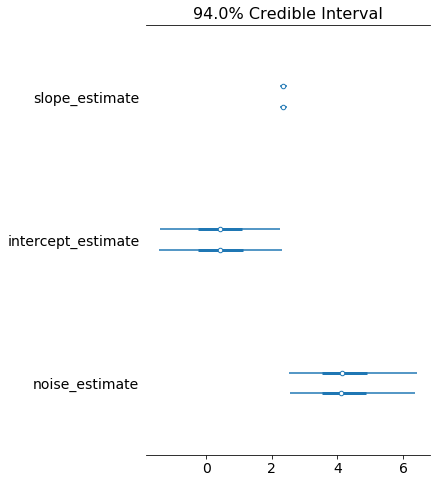

In [6]:
with pm.Model() as linear_model:
    
    slope_estimate = pm.Normal("slope_estimate", 0, 1)
    intercept_estimate = pm.Normal("intercept_estimate", 0, 1)
    
    # Noise is its own parameter
    noise_estimate = pm.HalfNormal("noise_estimate", 5)
    
    # The data follows a mean of y with a known noise
    y_estimate = pm.Normal("y_estimate",
                           # This is what we typically get from an OLS regression
                           mu=slope_estimate*x + intercept_estimate, 
                           
                           # This is the characterization of the noisea
                           sd=noise_estimate, observed=noisy_y)
    trace_linear_regression = pm.sample(draws=5000)
    

az.plot_forest(trace_linear_regression)

(<Figure size 432x302.4 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c227eb4a8>],
       dtype=object))

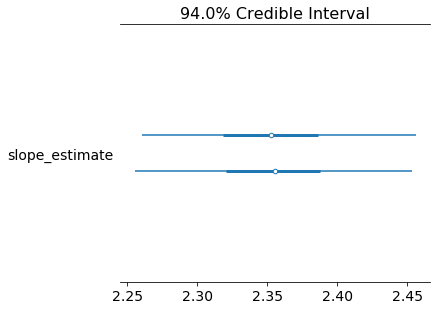

In [7]:
az.plot_forest(trace_linear_regression, var_names = ["slope_estimate"])

## Simulating Draws through Posterior Predictive sampling
Bayes Models are generative meaning you're able to generate what new 

In [8]:
ppc = pm.sample_posterior_predictive(trace_linear_regression, samples=2000, model=linear_model)

100%|██████████| 2000/2000 [00:02<00:00, 801.62it/s]


In [9]:
ppc["y_estimate"].shape

(2000, 10)

## Plot uncertainty with data
Uncertainty estimates give us range estimates that can characterize either  the underlying noise, or the uncertainty due to a low number of observations.
Note: In making this tutorial I ran into a possible bug in ArviZ. Hopefully we don't hit it in the tutorial.

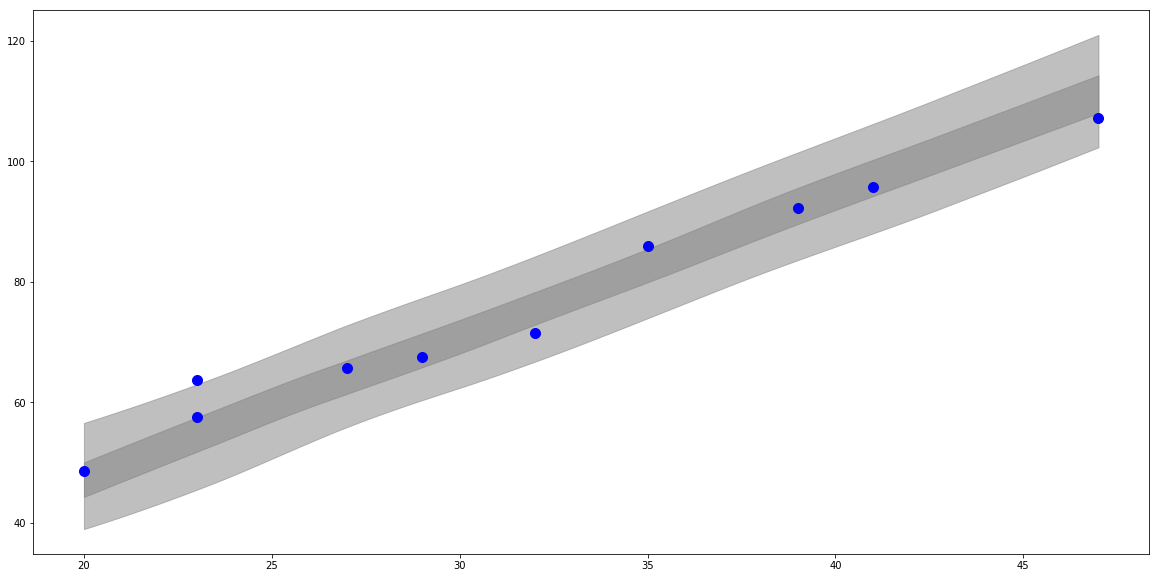

In [10]:
fig, ax = plt.subplots(figsize=(20,10))

az.plot_hpd(x, ppc['y_estimate'], credible_interval=0.5, color='gray', ax=ax)
az.plot_hpd(x, ppc['y_estimate'], credible_interval=0.94, color='gray', ax=ax)
plt.plot(x, noisy_y, 'b.', markersize=20)

## Are there real world examples?

Let's just jump to the best [public example I've seen](https://render.githubusercontent.com/view/ipynb?commit=bde6534c5543ca4af56fd19e845c4d6193b064ec&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f43616d4461766964736f6e50696c6f6e2f50726f626162696c69737469632d50726f6772616d6d696e672d616e642d426179657369616e2d4d6574686f64732d666f722d4861636b6572732f626465363533346335353433636134616635366664313965383435633464363139336230363465632f43686170746572315f496e74726f64756374696f6e2f4368315f496e74726f64756374696f6e5f50794d43332e6970796e62&nwo=CamDavidsonPilon%2FProbabilistic-Programming-and-Bayesian-Methods-for-Hackers&path=Chapter1_Introduction%2FCh1_Introduction_PyMC3.ipynb&repository_id=7607075&repository_type=Repository#Introducing-our-first-hammer:-PyMC3) in Bayesian Method for Hackers written by Cam Davidson Pilon

## Benefits of Bayesian Modeling (From this lecture)
1. Uncertainty estimates help statistician further decide how much can be inferred from data
2. Generative modeling allows simulation of what the future will look like with past data
3. Ability to create models for different situations (or data generating methods) flexibly

## Modeling heteroskedastic data
This one's a more challenging exercise. Using your Bayesian skills

In [11]:
np.random.seed(0)
sample_size = 300

# Generate random values between 1 and 50
x = np.random.randint(1, 10, sample_size)

intercept = 10
slope = 2

# Generate y values using out slope and intercept
y= x * slope + intercept

# Add some noise in using a zero centered Gaussian/Normal Distribution
noise = .2
noisy_y = y + stats.norm(0, noise).rvs(sample_size)*x

x[:10], noisy_y[:10]

(array([6, 1, 4, 4, 8, 4, 6, 3, 5, 8]),
 array([23.01355124, 12.18172848, 18.78593725, 17.0552393 , 26.14391008,
        17.43500406, 22.06267001, 15.19505251, 21.38294233, 26.61906054]))

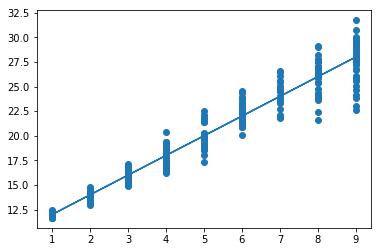

In [12]:
fig, ax = plt.subplots()

# Plot Dots
ax.scatter(x, noisy_y)

# Plot Best Fit Line
_x = np.linspace(0, 20, 1000)
ax.plot(x, x * slope + intercept)

## Fill in model here
Fit a bayes model to recover the noise coefficient to understand how our process variability increases over time. Use posterior plots to check if you're able to get the value from above.
Hint:
* Think about what is different here from constant varying noise linear model
* How would you express the difference to a Bayes Model


In [ ]:
# Insert model!

## Additional Advanced Topics

### Hierachial Regressions
Bayesian Methods allow for a concept of hierarchial pooling, where multiple subgroups can share inforation from a pooled group. This is a great way to make the most of sparse datasets. A good example of this is Radon Levels in basements, where many counties only have a couple measurements, but overall there are a couple hundred measurements. 

### Other Bayesian Model Types
* Gaussian Processes
* Mixture Modeling
* Bayesian Ordinary Differential Equations
* Bayesian Survival Analysis
* Bayesian Neural Networks
* Others I'm sure I'm missing

### Decision Analysis
The generative model part becomes really great with decision analysis, which lets you optimize future choices. An example [optimizing the best place to buy material from](http://canyon289.github.io/BayesianDecisionMaking.html#BayesianDecisionMaking)

### You get to work with an amazing group of people making cool open source software to freely share knowledge with the world!!!!
Ok sure this one doesn't look like the others, but really the people I've worked interacted with in the Bayesian community are fantastic. If you're looking to join an open source community I've found no better. Feel free to reach out to me or check out the contributing guide on the repos. Or show up to PyDataLA where we are running open source sprints!